# Play with NLP
* https://spacy.io/
* https://www.nltk.org/

In [1]:
"""
from sklearn.datasets import fetch_openml
from sklearn import datasets, svm, metrics
from pandas import DataFrame
import matplotlib as mpl
"""

from typing import List, Tuple
from dataclasses import dataclass
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import glob
import os
from pathlib import Path

# get nltk and corpus
import nltk
from nltk.corpus import stopwords

# get scapy and corpus
import spacy
import time
from functools import lru_cache

In [2]:
# This function is in the first block so you don't
# recreate it willy nilly, as it includes a cache.

nltk.download("stopwords")

# Remove domain words that don't help analysis.
# Should be factored out
domain_stop_words = set(
    """
    yes yup Affirmations get that's
    Deliberate Disciplined Daily
    Know Essential Provide Context
    First Understand Appreciate
    """.lower().split()
)


@lru_cache(maxsize=4)
def get_nlp_model(model: str):
    start_time = time.time()
    print(f"Loading Model {model}")
    nlp = spacy.load(model)  # python -m spacy download en_core_web_lg
    spacy.prefer_gpu()  # This will be cool if/when it happens.
    duration = time.time() - start_time
    print(f"Took: {int(duration)}")
    return nlp


# Load corpus of my daily ramblings
@dataclass(frozen=True)
class Corpus:
    path: str
    all_content: str
    initial_words: List[str]
    words: List[str]

    def __hash__(self):
        return self.path.__hash__()


@lru_cache(maxsize=10)
def LoadCorpus(corpus_path: str) -> Corpus:

    # Hym consider memoizing this asweel..
    english_stop_words = set(stopwords.words("english"))
    all_stop_words = domain_stop_words | english_stop_words

    corpus_path_expanded = os.path.expanduser(corpus_path)
    corpus_files = glob.glob(corpus_path_expanded)

    """
    ######################################################
    # Performance side-bar.
    ######################################################

    A] Below code results in all strings Loaded into memory for temporary,  then merged into a second string.
    aka Memory = O(2*file_conent) and CPU O(2*file_content)

    B] An alternative is to do += on a string results in a new memory allocation and copy.
    aka Memory = O(file_content) , CPU O(files*file_content)

    However, this stuff needs to be measured, as it's also a funtion of GC. Not in the GC versions there is no change in CPU
    Eg.

    For A] if GC happens after every "join", then were down to O(file_content).
    For B] if no GC, then it's still O(2*file_content)
    """

    # Make single string from all the file contents.
    list_file_content = [Path(file_name).read_text() for file_name in corpus_files]
    all_file_content = " ".join(list_file_content)

    # Clean out some punctuation (although does that mess up stemming later??)
    initial_words = all_file_content.replace(",", " ").replace(".", " ").split()

    words = [word for word in initial_words if word.lower() not in all_stop_words]
    return Corpus(
        path=corpus_path,
        all_content=all_file_content,
        initial_words=initial_words,
        words=words,
    )


@lru_cache(maxsize=10)
def DocForCorpus(nlp, corpus: Corpus):
    print(
        f"initial words {len(corpus.initial_words)} remaining words {len(corpus.words)}"
    )
    print(f"Building corpus from {corpus.path} of len:{len(corpus.all_content)} ")
    start_time = time.time()
    # We use all_file_content not initial_words because we want to keep punctuation.
    doc_all = nlp(corpus.all_content)
    duration = time.time() - start_time

    # Remove domain specific stop words.
    doc = [token for token in doc_all if token.text.lower() not in domain_stop_words]
    print(f"Took: {int(duration)}")
    return doc

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/idvorkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# make the plot wider
height_in_inches = 8
matplotlib.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

### Load corpus from my journal

In [4]:
corpus_path = "~/gits/igor2/750words/2018*md"
# corpus_path = "/mnt/c/Users/idvor/OneDrive/backup/Diary/*txt"

corpus = LoadCorpus(corpus_path)
print(f"initial words {len(corpus.initial_words)} remaining words {len(corpus.words)}")

initial words 51189 remaining words 25075


In [5]:
# Could use nltk frequency distribution, but better off building our own.
# fd = nltk.FreqDist(words)
# fd.plot(50, percents=True)

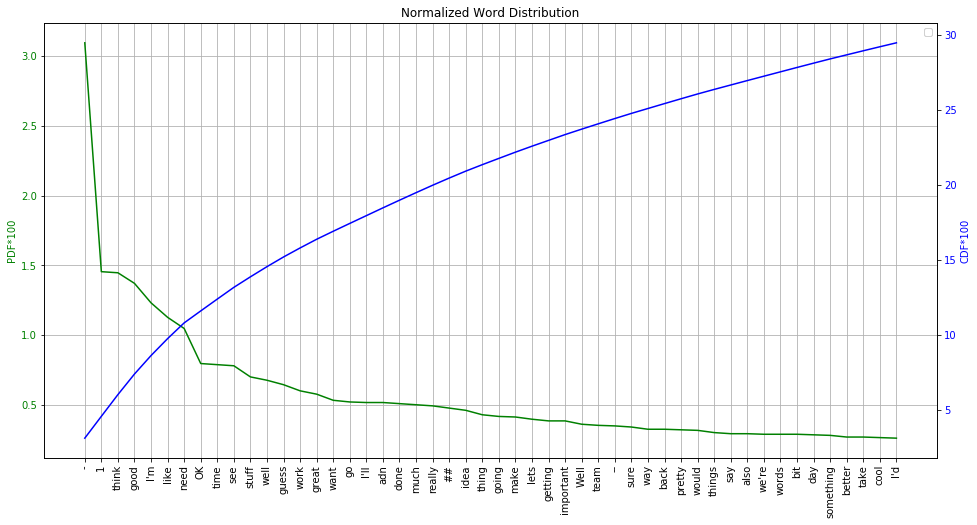

In [6]:
# Same as NLTK FreqDist, except normalized, includes cumsum, and colors
def GraphWordDistribution(words, title="", skip=0, length=50, includeCDF=True) -> None:
    def GetPDFCDF(words):
        def ToPercent(x: float) -> float:
            return x * 100

        # NOTE: No point creating a full data frame when only using a single column.
        pdf = pd.Series(words).value_counts(normalize=True).apply(ToPercent)
        cdf = pdf.cumsum()
        return (pdf, cdf)

    def PlotOnAxis(series, ax, label: str, color: str):
        # RANT: Why is MPL so confusing? The OO interface vs the stateful interface, GRAH!!
        # The random non-obvious calls.
        # GRAH!!!

        ax.legend(label.split())
        ax.plot(series, color=color)

        # RANT: Why no YAxis.set_labal_params()? E.g.
        #                 ax.yaxis.set_label_params(label, color=color)
        ax.set_ylabel(label, color=color)
        ax.yaxis.set_tick_params(labelcolor=color)

        # technically all the X axis paramaters are duplicated since we "twinned the X paramater"
        ax.xticks = range(len(series))

        # RANT: rot can be set on plt.plot(), but not on axes.plot()
        ax.xaxis.set_tick_params(rotation=90)

    # NOTE: can make graph prettier with styles E.g.
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(1)

    ax.set_title(title)
    ax.grid(True)

    # make pdf first axes, and cdf second axes.
    ax_pdf, ax_cdf = (ax, ax.twinx())
    color_pdf, color_cdf = ("green", "blue")
    pdf, cdf = GetPDFCDF(words)

    PlotOnAxis(pdf[skip : skip + length], ax_pdf, label="PDF*100", color=color_pdf)
    PlotOnAxis(cdf[skip : skip + length], ax_cdf, label="CDF*100", color=color_cdf)


GraphWordDistribution(corpus.words, title="Normalized Word Distribution")

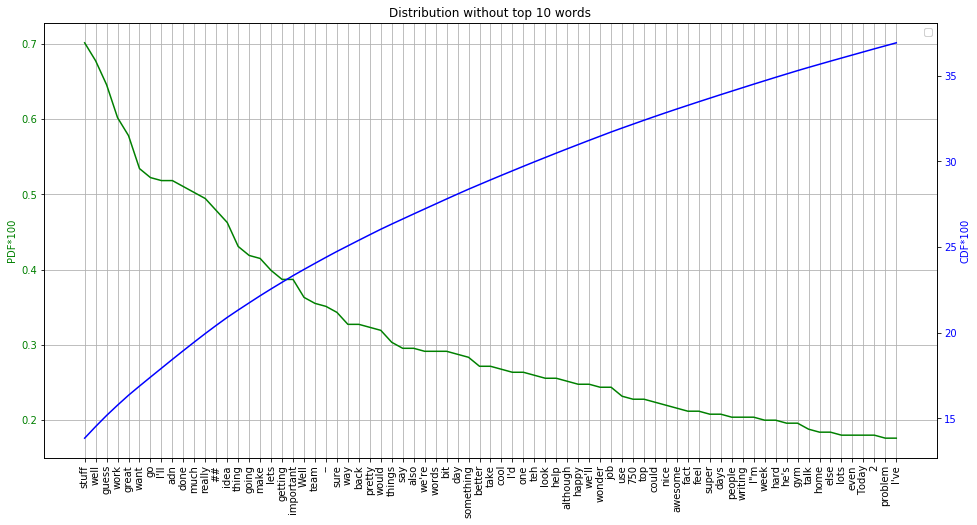

In [7]:
skip = 10
GraphWordDistribution(
    corpus.words, skip=skip, length=75, title=f"Distribution without top {skip} words"
)

In [8]:
# wordcloud is non-deterministic, which is bizarre.
# from wordcloud import WordCloud
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=None).generate("".join(words))
# plt.imshow(wordcloud,  interpolation='bilinear')

# Play with POS tagging and lemmatisation

In [20]:
nlp = get_nlp_model("en_core_web_lg")
nlp.max_length = 100 * 1000 * 1000


def GraphPoSForDoc(pos, doc):
    interesting_pos = pos
    interesting_pos_set = set(interesting_pos.split())
    interesting = [token for token in doc if token.pos_ in interesting_pos_set]
    interesting_words = [token.lemma_ for token in interesting]

    GraphWordDistribution(
        interesting_words,
        title=f"Distribution of {interesting_pos} on {corpus_path}",
        skip=0,
        length=50,
    )


def GraphScratchForCorpus(corpus_path: str, pos: str = "NOUN VERB ADJ ADV"):
    nlp = get_nlp_model("en_core_web_lg")
    corpus = LoadCorpus(corpus_path)
    doc = DocForCorpus(nlp, corpus)
    GraphPoSForDoc(pos, doc)

In [ ]:
corpus_paths = [
    "~/gits/igor2/750words/2018*md",
    "~/gits/igor2/750words/2019*md",
    "/mnt/c/Users/idvor/OneDrive/backup/Diary/*2012*txt",
    "/mnt/c/Users/idvor/OneDrive/backup/Diary/*2011*txt",
]

for c in corpus_paths:
    GraphScratchForCorpus(c, pos="NOUN")

initial words 280032 remaining words 145062
Building corpus from /mnt/c/Users/idvor/OneDrive/backup/Diary/*2012*txt of len:1453680 


# Debugging when stuff goes goofy.

In [14]:
_ = """
max_to_analyze = 15
interesting = [token for token in doc if token.tag_ == "NNS"]
for token in interesting[:max_to_analyze]:
    # print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)

# Parts of speech: https://spacy.io/usage/linguistic-features
GraphWordDistribution([token.pos_ for token in doc], title=f"POS Distribution on {corpus_path}")
# interesting = [ token for token in doc if token.pos_ != "PUNCT" and token.pos_ != "SYM" and len(token.text) > 3]
"""